In [13]:
# Name: Zeyun Wu
# Date: July 5th 2019

import numpy as np
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import ToyQ2

In [3]:
# sigmoid function for nd; return the value of sigmoid with argument beta
# q can be n dimensional, either list or int/float
# beta should be between 0 and 1; determine the sharpness of sigmoid
# we can also try different functions here
def sigmoid(beta,q):
    q=np.array(q)
    val = 1/(1+np.exp(0-beta*q))
    return val
def ratchose(Q): # 0 means left
    if random.uniform(0,1)<sigmoid(beta,Q[0]-Q[1]):
        return np.array([1,0])
    else:
        return np.array([0,1]) 

In [5]:
# demo
env=toyQ_2choice()
rat=sig_rat(env,alpha=0.2,beta=2)
env,rat=train_rat(env,rat,300)
obslog=np.array(env.obslog)
choicelog=np.array(rat.choiceLog) 
print('reward_log:',np.sum(obslog,axis=0))
print('choice_log:',np.sum(choicelog,axis=0))
rat.Q

reward_log: [ 12 187]
choice_log: [ 63 237]


array([[0.19403833, 0.5085361 ]])

## Maximum Likelihood Estimation on beta

we cannot give MLE for Q's since likelihood is a function of Q, that is, Q is changing at every timepoint

Given the actions(i.e. the turns) and Q value of the agent in every round, maximum likelihood estimation of beta are given here.

The action of agent is given by a sigmoid-like function of Q, beta as a parameter.

In [7]:
#for test use
#actions = np.random.choice([0,1], size=3, p=[0.2,0.8]) # 0=left, 1=right
#rewards = np.random.choice([0,1], size=3, p=[0.2,0.8])

In [8]:
#Q = np.array([[0,0],[0,0.2],[0.2,0.36]])    #,[0.36,0.688]
#beta0 = 0

In [32]:
# parameter: action, a list of numpy arrays of action data; reward, a list of np array of reward data
# beta, sharpness of sigmoid; alpha, learning rate
# return the sum of log-likelihood
def neg_log_likelihood_2Q(alpha,beta,actions,rewards,Q=[0,0],gamma=0): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = actions[i]
        rew = rewards[i]
        Q = Q + alpha*turn*(rew + gamma*np.max(Q)-Q)
        dQ = Q[0] - Q[1]
        if np.array_equal(turn,np.array([1,0])):
            prob = 1/(np.exp(0-beta*dQ)+1)
        else:
            prob = 1 - 1/(np.exp(0-beta*dQ)+1)
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll

In [33]:
# params = [alpha0,beta0]
# args = [actions,rewards]
def helper_func(params,args):
    alpha0 = params[0]
    beta0 = params[1]
    actions = args[0]
    rewards = args[1]
    
    sum_ll = neg_log_likelihood_2Q(alpha0,beta0,actions,rewards)
    
    return sum_ll

In [34]:
# function that estimates the maximum-likelihood beta_hat numerically
# parameters: actions, a numpy array recording action of agent in each turn; beta is the parameter in density func
# return minimization summary and print beta_hat
def MLE_grid(actions,rewards,alpha0,beta0):
    initial_guess = [alpha0,beta0]
    args = [actions,rewards]
    result = minimize(helper_func,initial_guess,args=args)
    if(result.success):
        #print(result.message)
        #print('The MLE for beta is', result.x)
        #print('Iteration =', result.nit)
        a=0
    else:
        print('The optimization did not converge, beta0 equals', beta0,', and alpha0 equals',alpha0)
    return result
    
    

In [35]:
# return mse between simulated Q and Q_hat calculated with optimal beta from MLE
def Q_distance(iteration,alpha0,beta0):
    env = toyQ_2choice()
    rat = sig_rat(env, alpha=alpha0, beta=beta0)
    env,rat = train_rat(env,rat,iteration)
    Q = np.array(rat.Qlog)
    actions = rat.choiceLog
    rewards = env.obslog
    
    result = MLE_grid(actions,rewards,alpha0,beta0)
    alpha_hat = result.x[0]
    beta_hat = result.x[1]
    
    rat_hat = sig_rat(env, alpha=alpha_hat, beta=beta_hat)
    env,rat_hat = train_rat(env,rat_hat,iteration)
    Q_hat = np.array(rat_hat.Qlog)
    
    #Q[0]=[0,0] does not matter
    mse = np.linalg.norm(Q-Q_hat)**2/iteration 
    #axis=None perform mean elementwise   (np.square(Q-Q_hat)).mean(axis=None)*2
    
    return mse
    
    

In [39]:
#test
Q_distance(300,0.2,4)

0.07166584375865978

In [118]:
#
mse_list = []
beta0_list = [-10,-4,-2,-1,-0.8,-0.5,-0.2,0.2,0.5,0.8,1,2,4,10]
alpha0_list = [0.1,0.3,0.5,0.7,0.9]
iteration=300
for i in range(len(beta0_list)):
    for j in range(len(alpha0_list)):
        mse = Q_distance(iteration,alpha0_list[j],beta0_list[i])
        mse_list.append(mse)

The optimization did not converge, beta0 equals -10 , and alpha0 equals 0.1


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1 , and alpha0 equals 0.9


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.5 , and alpha0 equals 0.1
The optimization did not converge, beta0 equals -0.5 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.3
The optimization did not converge, beta0 equals -0.5 , and alpha0 equals 0.5

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 0.2 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.7
The optimization did not converge, beta0 equals 0.5 , and alpha0 equals 0.3
The optimization did not converge, beta0 equals 0.8 , and alpha0 equals 0.1


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 10 , and alpha0 equals 0.7


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


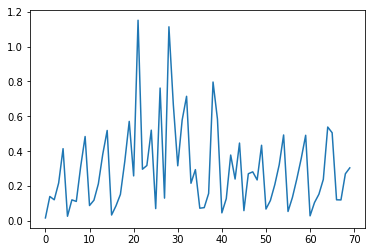

In [120]:
plt.plot(mse_list)
plt.show()

In [121]:
# return the optimal combination of alpha and beta that gives smallest mse between Q and Q_hat
def opt_alpha_beta(mse_list,alpha_list,beta_list):
    n = len(alpha_list)
    m = len(beta_list)
    
    mse_min = min(mse_list)
    
    for i in range(m):
        for j in range(n):
            if mse_list[(i-1)*n + j] == mse_min:
                return alpha_list[j],beta_list[i]
            
    

0.017995139521162173

# More 3D plot and test

In [40]:
# run simulation
env=toyQ_2choice()
rat=sig_rat(env,alpha=0.2,beta=2)
env,rat=train_rat(env,rat,300)
obslog=np.array(env.obslog)
choicelog=np.array(rat.choiceLog) 
print('reward_log:',np.sum(obslog,axis=0))
print('choice_log:',np.sum(choicelog,axis=0))
rat.Q

actions = rat.choiceLog
rewards = env.obslog
# true beta = 2, true alpha = 0.2

reward_log: [ 14 190]
choice_log: [ 64 236]


In [45]:
alpha0_list = np.linspace(0.1,0.3,20)
beta0_list = np.linspace(1.5,2.5,30)
MLE_grid(actions,rewards,0.27,2.8)

      fun: 152.28751886989886
 hess_inv: array([[ 0.00753013, -0.00308251],
       [-0.00308251,  0.06258052]])
      jac: array([-9.53674316e-06, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.2000889 , 2.28622751])

In [42]:
mse_list = []
iteration=300
for i in range(len(beta0_list)):
    for j in range(len(alpha0_list)):
        mse = Q_distance(iteration,alpha0_list[j],beta0_list[i])
        mse_list.append(mse)

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 1.5344827586206897 , and alpha0 equals 0.1105263157894737
The optimization did not converge, beta0 equals 1.5344827586206897 , and alpha0 equals 0.21578947368421053
The optimization did not converge, beta0 equals 1.5344827586206897 , and alpha0 equals 0.22631578947368422
The optimization did not converge, beta0 equals 1.5689655172413792 , and alpha0 equals 0.14210526315789473
The optimization did not converge, beta0 equals 1.5689655172413792 , and alpha0 equals 0.21578947368421053
The optimization did not converge, beta0 equals 1.5689655172413792 , and alpha0 equals 0.2578947368421053


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 1.6724137931034484 , and alpha0 equals 0.14210526315789473
The optimization did not converge, beta0 equals 1.6724137931034484 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.1842105263157895
The optimization did not converge, beta0 equals 1.6724137931034484 , and alpha0 equals 0.2578947368421053
The optimization did not converge, beta0 equals 1.706896551724138 , and alpha0 equals 0.22631578947368422
The optimization did not converge, beta0 equals 1.706896551724138 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.2789473684210526
The optimization did not converge, beta0 equals 1.7413793103448276 , and alpha0 equals 0.15263157894736842
The optimization did not converge, beta0 equals 1.7413793103448276 , and alpha0 equals 0.3
The optimization did not converge, beta0 equals 1.7758620689655173 , and alpha0 equals 0.13157894736842107


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 1.7758620689655173 , and alpha0 equals 0.3

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 1.9482758620689655 , and alpha0 equals 0.1105263157894737
The optimization did not converge, beta0 equals 1.9482758620689655 , and alpha0 equals 0.21578947368421053
The optimization did not converge, beta0 equals 1.9482758620689655 , and alpha0 equals 0.24736842105263157


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 1.9827586206896552 , and alpha0 equals 0.17368421052631577
The optimization did not converge, beta0 equals 1.9827586206896552 , and alpha0 equals 0.3
The optimization did not converge, beta0 equals 2.0517241379310347 , and alpha0 equals 0.14210526315789473
The optimization did not converge, beta0 equals 2.086206896551724 , and alpha0 equals 0.1
The optimization did not converge, beta0 equals 2.086206896551724 , and alpha0 equals 0.14210526315789473
The optimization did not converge, beta0 equals 2.086206896551724 , and alpha0 equals 0.2894736842105263
The optimization did not converge, beta0 equals 2.1206896551724137 , and alpha0 equals 0.1105263157894737
The optimization did not converge, beta0 equals 2.1206896551724137 , and alpha0 equals 0.1631578947368421
The optimization did not converge, beta0 equals 2.155172413793103 , and alpha0 equals 0.15263157894736842


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 2.155172413793103 , and alpha0 equals 0.20526315789473684
The optimization did not converge, beta0 equals 2.155172413793103 , and alpha0 equals 0.2368421052631579
The optimization did not converge, beta0 equals 2.189655172413793 , and alpha0 equals 0.21578947368421053
The optimization did not converge, beta0 equals 2.2586206896551726 , and alpha0 equals 0.20526315789473684


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 2.293103448275862 , and alpha0 equals 0.2578947368421053
The optimization did not converge, beta0 equals 2.3275862068965516 , and alpha0 equals 0.14210526315789473


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 2.362068965517241 , and alpha0 equals 0.19473684210526315
The optimization did not converge, beta0 equals 2.4310344827586206 , and alpha0 equals 0.1105263157894737
The optimization did not converge, beta0 equals 2.4655172413793105 , and alpha0 equals 0.1842105263157895


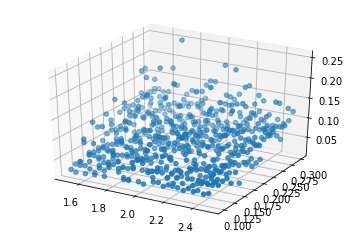

Text(0.0937963,0.0125663,'MSE between Q and Q_hat')

In [43]:
# 3d plot
alpha_plot = []
beta_plot = []
for i in range(len(beta0_list)):
    for j in range(len(alpha0_list)):
        alpha_plot.append(alpha0_list[j])
        beta_plot.append(beta0_list[i])

from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.counter3D(beta_plot,alpha_plot,mse_list2)
a = ax.scatter3D(beta_plot,alpha_plot,mse_list)
plt.show(a)
ax.set_xlabel('beta0')
ax.set_ylabel('alpha0')
ax.set_zlabel('MSE between Q and Q_hat')

In [46]:
bvals = np.linspace(2,6,20)
avals = np.linspace(0,0.4,20)
# ll = [neg_log_likelihood_2Q(0.2,b,actions,rewards) for b in bvals]
ll = []
for i in range(len(bvals)):
    for j in range(len(avals)):
        val = neg_log_likelihood_2Q(bvals[i],avals[j],actions,rewards)
        ll.append(val)

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


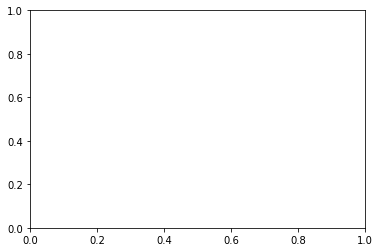

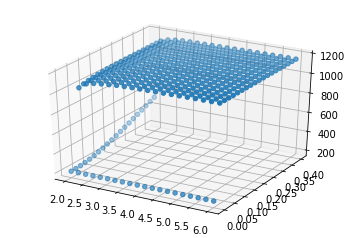

Text(0.0937963,0.0125663,'log-likelihood')

In [48]:
aval_plot = []
bval_plot = []
for i in range(len(bvals)):
    for j in range(len(avals)):
        aval_plot.append(avals[j])
        bval_plot.append(bvals[i])

from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.counter3D(beta_plot,alpha_plot,mse_list2)
a = ax.scatter3D(bval_plot,aval_plot,ll)
plt.show()
ax.set_xlabel('beta0')
ax.set_ylabel('alpha0')
ax.set_zlabel('log-likelihood')